# DC Government Purchasing
Analysis of government purchase orders 2004-2015

My interest was sparked by an article Homeless shelter plan could be profitable for Bowser’s backers https://www.washingtonpost.com/local/dc-politics/homeless-shelter-plan-could-be-profitable-for-bowsers-backers/2016/03/16/cbab0e76-eadc-11e5-b0fd-073d5930a7b7_story.html
D.C. Mayor Muriel E. Bowser has pitched her plan to create family homeless shelters in almost every ward of the city as an equitable way for the community to share the burden of caring for the neediest residents.

But records show that most of the private properties proposed as shelter sites are owned or at least partly controlled by major donors to the mayor. And experts have calculated that the city leases­ would increase the assessed value of those properties by as much as 10 times for that small group of landowners and developers.

How much taxpayer money would be paid to a handful of well-connected private landowners, developers and their agents is expected to be a focus of a hearing Thursday before the D.C. Council.

http://www.bayesimpact.org/stories/?name=the-mob-the-money-and-the-mayhem
How Network Analysis Can Help Identify Money Laundering Schemes
Written by Jonathon Morgan, Platform Architect at Ushahidi and Founder of CrisisNET 
Using Eliot’s tip and a public database of registered UK companies, we investigated whether a network analysis approach could identify potential smoking guns — sham companies, shady business connections, or at least organizations with the capacity for offshore money laundering.
## Questions of interest
Is it possible to identify transactions in a large dataset that may warrant further scrutiny?
Which commodities and purchase sizes are most attractive for fraud or sleeze?

In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline 
#this line above prepares IPython notebook for working with matplotlib

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().

import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
import seaborn as sns #sets up styles and gives us more plotting options

import statsmodels
import sklearn
import nltk



from datetime import datetime

#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
print("numpy:", np.__version__)
print("scipy:", sp.__version__)
print("matplotlib:", mpl.__version__)
print("statsmodels:", statsmodels.__version__)
print("pandas:", pd.__version__)
print("seaborn:", sns.__version__)
print("sklearn:", sklearn.__version__)
print("nltk:", nltk.__version__)

numpy: 1.10.4
scipy: 0.17.0
matplotlib: 1.5.1
statsmodels: 0.6.1
pandas: 0.17.1
seaborn: 0.7.0
sklearn: 0.17
nltk: 3.1


## Data Wrangling
The data is available at http://data.octo.dc.gov/ from 2004-2015 through csv files and excel. I unzipped the cvs files and converted the excel files to csv. The 2013 excel file was in the xlsx format, but converted easily.

On inspection, the files and headers are structured in 3 distinct ways. 

The 2010 cvs would not import properly. On further inspection there was an item with quotes inside quotes, which caused the columns to not break properly. Line 7119:
"PENCILS, MARKING (INCLUDING MECHANICAL TYPES AND REFILLS): "GREASE" OR "CHINA" TYPES, ETC. 70"


In [6]:
def load_data():
    
    list_ = []
    
    for file_ in ["data/Purchase_order_FY14.csv", "data/Purchase_order_FY15.csv"]:
        df = pd.read_csv(file_, header=0, names=['agency', 'commodity', 'supplier', 'order_date','po', 'amount'])
        
        df = df[df['po'].notnull()]

        # data cleaning and type casting
        df['agency'] = df.agency.astype(str).str.lower()
        df['commodity'] = df.commodity.astype(str).str.lower()
        df['supplier'] = df.supplier.astype(str).str.lower()
        df['amount'] = df.amount.map(lambda x: x.replace(',', '')).astype(float)/1000
        df['order_date'] = pd.to_datetime(df['order_date'])

        list_.append(df)
    
    #PO Number	Agency	Commodity	Vendor Name	Ordered DAte	PO amount
    for file_ in ["data/Purchase_order_FY12.csv", "data/Purchase_order_FY13.csv"]:
        df = pd.read_csv(file_, header=3, names=['po', 'agency', 'commodity', 'supplier', 'order_date', 'amount'])
        df = df[df['po'].notnull()]

        # data cleaning and type casting
        df['agency'] = df.agency.astype(str).str.lower()
        df['commodity'] = df.commodity.astype(str).str.lower()
        df['supplier'] = df.supplier.astype(str).str.lower()
        df['amount'] = df.amount.map(lambda x: x.replace(',', '')).astype(float)/1000
        df['order_date'] = pd.to_datetime(df['order_date'])

        list_.append(df)
    
    # PO_NUMBER,AGENCY_NAME,NIGP_DESCRIPTION,PO_TOTAL_AMOUNT,ORDER_DATE,SUPPLIER,SUPPLIER_FULL_ADDRESS,SUPPLIER_CITY,SUPPLIER_STATE
    # "pass_2004_CSV.csv", "pass_2008_CSV.csv", "pass_2009_CSV.csv", "pass_2010_CSV.csv", 
    files = ["data/pass_2004_CSV.csv", "data/pass_2008_CSV.csv", "data/pass_2009_CSV.csv", "data/pass_2010_CSV.csv", "data/pass_2011_CSV.csv"]
    
    for file_ in files:
    
        df = pd.read_csv(file_, skiprows=1, names=['po', 'agency', 'commodity', 'amount', 'order_date', 'supplier', 'supplier_address', 'supplier_city', 'supplier_state'])

        df = df[df['po'].notnull()]

        # data cleaning and type casting
        df['agency'] = df.agency.astype(str).str.lower()
        df['commodity'] = df.commodity.astype(str).str.lower()
        df['supplier'] = df.supplier.astype(str).str.lower()
        df['amount'] = df.amount.map(lambda x: x.replace(',', '')).map(lambda x: x.replace('$', '')).astype(float)/1000
        df['order_date'] = pd.to_datetime(df['order_date'])

        list_.append(df)
        
    df_result = pd.concat(list_)
        
    df_result = df_result[df_result['amount'] > 0]
        
    print("Data loaded")

    return df_result

df = load_data()

Data loaded


In [15]:
# top agencies
agencies = df.groupby(['agency','commodity'])['amount'].agg(['sum', 'mean', 'count'])
agencies = agencies.sort_values(by=['sum'],ascending=False)

agencies.head(10)

sum         mean  count
agency                                 commodity                                                                            
department of general services         9582600:construction management services            1542591.08108   601.165659   2566
public charter schools                 support services 85                                 1227185.02580  1027.793154   1194
                                       school operation and management services 71         1001555.65658  1138.131428    880
off public ed facilities modernization construction management services 26                  882256.75750   500.997591   1761
department of transportation           engineering consulting 42                            714622.89105  2198.839665    325
dept. of housing and comm. development professional services (not otherwise classified...   455823.17827   576.261919    791
department of transportation           9132700:construction, highway and road               394898.19377   746.499421    529
department of human services           emergency shelter 37                                 315031.39940  2647.322684    119
                                       9523700:emergency shelter                            313463.86610  1405.667561    223
housing production trust fund          loan administration 60                               312063.43879  2080.422925    150

In [14]:
# top suppliers
suppliers = df.groupby(['supplier'])['amount'].agg(['sum', 'mean', 'count'])
suppliers = suppliers.sort_values(by=['sum'],ascending=False)
    
suppliers.head(10)

,sum,mean,count
supplier,,,
skanska-facchina jv,858620.42212,28620.680737,30
the community partnership\home,675299.86433,2071.471976,326
fort myer construction corpora,662168.73850,1285.764541,515
turner construction company,609678.77505,1098.520315,555
defense logistic agency,476484.90083,4581.585585,104
friendship pcs,419838.69862,1679.354794,250
"ost, inc.",320940.42162,57.096677,5621
corrections corporation of,277383.41400,11557.642250,24
capitol paving of dc inc,273014.33291,1070.644443,255


In [16]:
def suppliers_by_year(floor=1, ceiling=5000000):
    
    years = range(2004,2016)
    df_suppliers_by_year = pd.DataFrame()
    
    # filter by floor and ceiling of amount
    df_filtered = df[df['amount'] > floor]
    df_filtered = df_filtered[df_filtered['amount'] < ceiling]
    
    for _year in years:

        mask = (df_filtered['order_date'].dt.year == _year)
        
        supplier_sum_by_year = df_filtered.loc[mask].groupby(['supplier'])['amount'].agg(['sum'])
                
        supplier_sum_by_year=supplier_sum_by_year.rename(columns = {'sum':_year})
        
        df_suppliers_by_year = pd.merge(df_suppliers_by_year, supplier_sum_by_year, left_index=True, right_index=True, how="outer")
                
        df_suppliers_by_year.fillna(0, inplace=True)

    return df_suppliers_by_year

print (suppliers_by_year().describe())
print (suppliers_by_year().head())

               2004          2005          2006          2007           2008          2009           2010           2011           2012           2013           2014          2015
count  19659.000000  19659.000000  19659.000000  19659.000000   19659.000000  19659.000000   19659.000000   19659.000000   19659.000000   19659.000000   19659.000000  19659.000000
mean      49.367779     73.383043    106.143010    137.491997     173.447370    131.881378     178.404773     190.192724     155.819880     139.449142     181.523371     29.560073
std      644.502575    844.477245   1039.985621   1461.928505    2270.805284   1381.235359    3600.791805    2971.009649    2291.161648    1814.443714    2338.904934    490.520664
min        0.000000      0.000000      0.000000      0.000000       0.000000      0.000000       0.000000       0.000000       0.000000       0.000000       0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.000000       0.000000      0.000000       0.0

In [17]:
def suppliers_change(floor=1, ceiling=5000000):
    
    df_suppliers_change = suppliers_by_year(floor, ceiling)
    
    years = range(2015, 2004, -1)
    
    for _year in years:

        df_suppliers_change[_year] = abs(df_suppliers_change[_year] - df_suppliers_change[_year - 1])/df_suppliers_change[_year - 1]
    
        # smooth out the tails where contracts begin and end
        _outliers = 2.0
        
        df_suppliers_change.ix[df_suppliers_change[_year] > _outliers, _year] = _outliers
        df_suppliers_change.ix[df_suppliers_change[_year] < -_outliers, _year] = -_outliers
    
    return df_suppliers_change

print (suppliers_change().describe())
print (suppliers_change().head())

               2004         2005         2006         2007         2008         2009         2010         2011         2012         2013         2014         2015
count  19659.000000  5350.000000  6460.000000  6979.000000  7735.000000  7207.000000  7165.000000  6584.000000  6537.000000  6780.000000  7058.000000  5649.000000
mean      49.367779     1.342558     1.271444     1.218252     1.257996     1.157366     1.162884     1.213250     1.218942     1.162130     1.215950     1.001928
std      644.502575     0.694227     0.695500     0.687588     0.660003     0.675310     0.665858     0.647553     0.673229     0.683402     0.702270     0.335157
min        0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000
25%        0.000000     0.930261     0.816936     0.736159     1.000000     0.666680     0.734674     0.901028     0.735233     0.666667     0.683467     1.000000
50%        0.000000   

        change
year          
2005  1.342558
2006  1.271444
2007  1.218252
2008  1.257996
2009  1.157366
2010  1.162884
2011  1.213250
2012  1.218942
2013  1.162130
2014  1.215950
2015  1.001928
                              2004  2005      2006      2007  2008      2009  2010  2011     2012  2013  2014  2015
supplier                                                                                                           
1 ebt corp/dba ebt bus tours     0   NaN       NaN       NaN     2  1.000000   NaN   NaN      NaN   NaN   NaN   NaN
1 vision solutions, llc          0   NaN       NaN       NaN   NaN       NaN     2     1      NaN   NaN   NaN   NaN
1-pwr communications  llc        0   NaN  2.000000  1.000000   NaN       NaN   NaN   NaN      NaN   NaN   NaN   NaN
1000 k, llc (embassy suites)     0   NaN       NaN       NaN     2  1.000000   NaN   NaN      NaN     2     1   NaN
1001 restaraunt corporation      0     2  0.113553  0.852316     2  0.777099     1     2  0.19577     2     1

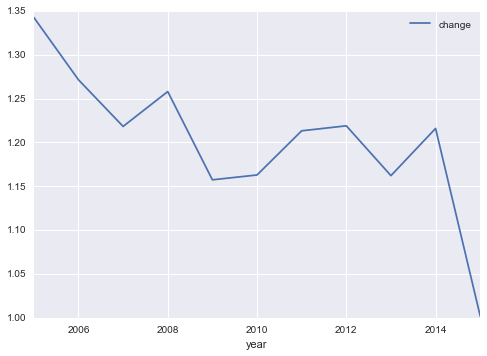

In [18]:
suppliers_change(floor=1, ceiling=5000000)

years = range(2005,2016)

year = []
change = []

for _year in years:

    year.append(_year)
    mean = suppliers_change()[_year].mean()
    change.append(mean)
    
df_change = pd.DataFrame({'year' : year, 'change' : change})
df_change.set_index(['year'], inplace = True)

print (df_change)

print (suppliers_change().head())

#print df_change

#df_change.sort(['year'])
df_change.plot()
#df_change.describe()

In [21]:
# try random floor and ceiling to see if there's a sweet spot with high change
#
# 2004 higher than 2005 and 2006
# 2012 higher than 2013 and 2014
# 2008 higher than 2009 and 2010
#
# max is $254m
from random import randint

i = 0
count = []
floor = []
ceiling = []
#peak2004 = []
peak2008 = []
peak2012 = []

while i < 200:
            
    i = i + 1

    # random floor
    # random ceiling between floor and 254m
    # check is at least 30 rows returned
    # save to array
    
    _floor = randint(0,50000)
    _ceiling = randint(_floor,254000)
    
    #_peak2004 = suppliers_change(floor=_floor, ceiling=_ceiling)[2004].mean() * 2 / (suppliers_change(floor=_floor, ceiling=_ceiling)[2005].mean() + suppliers_change(floor=_floor, ceiling=_ceiling)[2006].mean())
    _peak2008 = suppliers_change(floor=_floor, ceiling=_ceiling)[2008].mean() * 2 / (suppliers_change(floor=_floor, ceiling=_ceiling)[2009].mean() + suppliers_change(floor=_floor, ceiling=_ceiling)[2010].mean())
    _peak2012 = suppliers_change(floor=_floor, ceiling=_ceiling)[2012].mean() * 2 / (suppliers_change(floor=_floor, ceiling=_ceiling)[2013].mean() + suppliers_change(floor=_floor, ceiling=_ceiling)[2014].mean())

    # isinstance(x, numbers.Number)
    #if (suppliers_change(floor=_floor, ceiling=_ceiling)[2008].count() > 30):
    count.append(suppliers_change(floor=_floor, ceiling=_ceiling)[2008].count())
    floor.append(_floor)
    ceiling.append(_ceiling)
    #peak2004.append(_peak2004)
    peak2008.append(_peak2008)
    peak2012.append(_peak2012)


df_change = pd.DataFrame({'count' : count, 'floor' : floor, 'ceiling' : ceiling, 'peak2008' : peak2008, 'peak2012' : peak2012})

print (df_change)

# #df_change.sort(['year'])
# df_change.plot()

     ceiling  count  floor  peak2008  peak2012
0     200770      1  46131  1.333333  1.206671
1     130684      1  41591  1.333333  1.414141
2     103633    301   1476  1.185659  1.000804
3      48694      0  47583       NaN       NaN
4     164060     12  22652  1.176020  1.445625
5      12299    310   1351  1.168551  0.996894
6      65107      2  34636  1.000000  1.862590
7     232169      1  48749  1.333333  1.206671
8      55995      0  46163       NaN  1.714286
9      45308      3  33507  1.111111  1.988930
10    169237     25  13720  0.962191  1.137424
11     69354      1  40782  1.333333  1.500000
12    145927      9  24158  1.055295  1.524990
13    226980      7  27492  1.146126  1.427410
14    110371      3  31831  1.520680  1.688699
15     49892      0  43663       NaN       NaN
16    239748      2  41862  1.333333  1.273918
17     60834      0  46766       NaN  1.411765
18    165364      2  41603  1.333333  1.273918
19     35881     34  10164  0.921739  1.151241
20    219094 

In [ ]:
suppliers_change(floor=9000, ceiling=91000)

In [ ]:
df_change.describe()
df_change[df_change['count'] > 30].sort_values(by=['peak2008'], ascending=False)
# for 2012 
# count ~ 40
# $10m to #91m with outliers = 10
# $9m to #87m with outliers = 2
#
# for 2008 
# count ~ 150
# $2m to $28m with outliers = 10
# $3m to $19m with outliers = 2
# bump is about 30%